In [1]:
from pathlib import Path

train_path = Path("titanic-data", "train.csv")
test_path = Path("titanic-data", "test.csv")

In [2]:
import pandas as pd

train_df = pd.read_csv(train_path)
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Data Dictionary provided here: https://www.kaggle.com/competitions/titanic/data?select=train.csv

`Survived`: binary indicator of whether passenger (identified by `PassengerId` column) survived the Titanic tragedy

`Pclass`: ticket class, where 1 is first class, 2 is second class, and 3 is third class.

`Name`: Name of passenger

`Sex`: sex of the passenger

`Age`: age of the passenger

`SibSp`: number of siblings or spouses aboard the Titanic

`Parch`: number of parents or children aboard the Titanic

`Ticket`: ticket number

`Fare`: passeger fare

`cabin`: cabin number

`embarked`: port of embarkation

I'm not a huge fan of these column names, so I'm going to rename them.

In [4]:
def rename_columns(df: pd.DataFrame) -> pd.DataFrame:
    "Rename columns for my personal taste."
    return df.rename(columns={
        "PassengerId": "passenger_id",
        "Survived": "did_survive",
        "Pclass": "ticket_class",
        "Name": "passenger_name",
        "Sex": "sex",
        "Age": "age",
        "SibSp": "sibling_spouse_count",
        "Parch": "parent_child_count",
        "Ticket": "ticket_number",
        "Fare": "ticket_fare",
        "Cabin": "cabin_number",
        "Embarked": "embarkation_port",
    })

def submission_rename(df: pd.DataFrame) -> pd.DataFrame:
    """A certain schema is expected for the submission, so this function will need to be run on whatever data I submit to Kaggle."""
    return df.rename(
        columns={
            "did_survive": "Survived",
            "passenger_id": "PassengerId",
        }
    )[["PassengerId", "Survived"]]

train_df = rename_columns(train_df)
train_df.columns

Index(['passenger_id', 'did_survive', 'ticket_class', 'passenger_name', 'sex',
       'age', 'sibling_spouse_count', 'parent_child_count', 'ticket_number',
       'ticket_fare', 'cabin_number', 'embarkation_port'],
      dtype='object')

There are a few columns right off the bat which I expect should have no predictive power: `passenger_name`, `passenger_id`, and `ticket_number`. It is plausible that `cabin_number` could have predictive power, but that might require spatial information about the titanic, so for now I'll also remove that. I'm not so certain about `embarkation_port`, so I'll at least take a look at the distribution there.

In [5]:
from plotnine import *

In [9]:
embark_survival_rates = train_df.groupby("embarkation_port").did_survive.agg(["sum", "count"]).assign(survival_rate=lambda x: x["sum"] / x["count"])
embark_survival_rates = embark_survival_rates.rename(columns={"sum": "survivors", "count": "passengers"})
embark_survival_rates

,survivors,passengers,survival_rate
embarkation_port,,,
C,93,168,0.553571
Q,30,77,0.389610
S,217,644,0.336957


Curiously, It does seem that Cherbourg had a higher survival rate thatn Queenstown or Southampton. Is that difference significant?

In [20]:
from statsmodels.stats.proportion import proportion_confint
from mizani.formatters import percent_format

In [22]:
lower, upper = proportion_confint(embark_survival_rates.survivors, embark_survival_rates.passengers, method="beta", alpha=0.05)
embark_survival_rates = embark_survival_rates.assign(lower=lower, upper=upper)
embark_survival_rates

,survivors,passengers,survival_rate,lower,upper
embarkation_port,,,,,
C,93,168,0.553571,0.475048,0.630171
Q,30,77,0.389610,0.280462,0.507520
S,217,644,0.336957,0.300493,0.374923


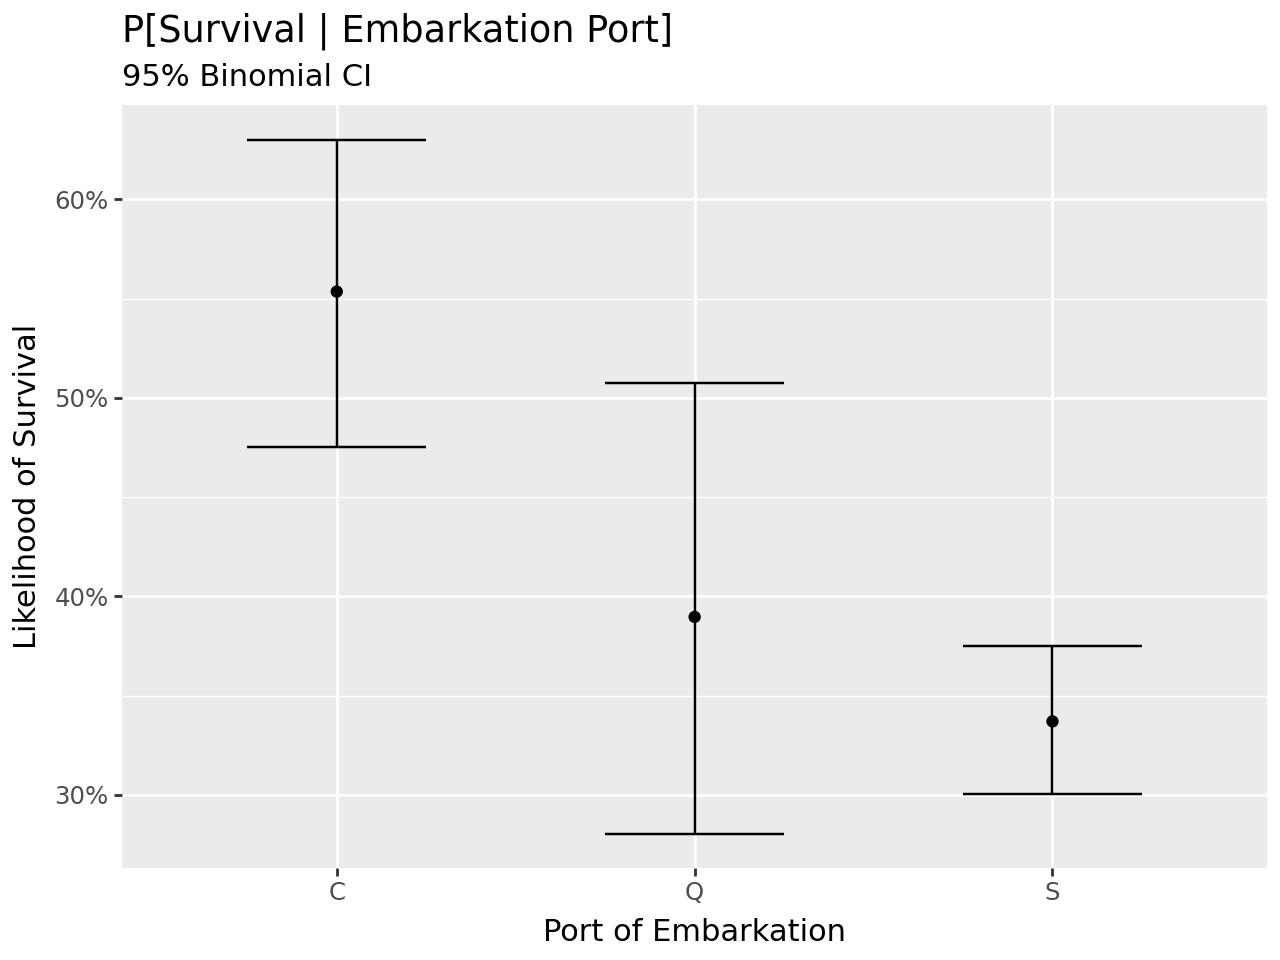

In [23]:
embarkation_ci_fig = (
    ggplot(embark_survival_rates.reset_index(), aes(x="embarkation_port", y="survival_rate", ymin="lower", ymax="upper"))
    + geom_errorbar()
    + geom_point()
    + labs(
        title="P[Survival | Embarkation Port]",
        subtitle="95% Binomial CI",
        y="Likelihood of Survival",
        x="Port of Embarkation",
    )
    + scale_y_continuous(labels=percent_format())
)
embarkation_ci_fig.show()

It does look like Port of Embarkation matters significantly when comparing `C` to `S` by about 20%, but it wouldn't surprise me if it correlates strongly with other features. We'll One Hot Encode this feature, though, and see how it appears in feature importance measures.

For now, I'm also curious how `age`, `sibling_spouse_count`, `parent_child_count`, and `ticket_fare` correlate with survival. Let's try using point biserial correlation coefficient.

In [33]:
from scipy.stats import pointbiserialr

# train_df[["age", "sibling_spouse_count", "parent_child_count", "ticket_fare", "did_survive"]].corr()
y = "did_survive"
X = ["age", "sibling_spouse_count", "parent_child_count", "ticket_fare"]
for x in X:
    stat, p = pointbiserialr(train_df[x].fillna(0), train_df[y])
    is_significant_flag = "not " if p > 0.05 else ""
    print(f"Correlation between {x} and {y} is {stat}, with a p-value of {p}, which is {is_significant_flag}significant.")

Correlation between age and did_survive is 0.010539215871285632, with a p-value of 0.7534004969396125, which is not significant.
Correlation between sibling_spouse_count and did_survive is -0.035322498885735625, with a p-value of 0.29224392869829086, which is not significant.
Correlation between parent_child_count and did_survive is 0.08162940708348349, with a p-value of 0.014799245374727947, which is significant.
Correlation between ticket_fare and did_survive is 0.25730652238496243, with a p-value of 6.1201893419246185e-15, which is significant.


So, generally, age doesn't matter, though that may be because only certain *extremes* in age matter. Similarly, sibling or spouse count doesn't matter. However, parent or child count *does* matter, though only slightly, as does ticket fare, though I would be surprised if ticket fare didn't correlate extremely with passenger class.

I suspect that sex is important for the parent/child count flag to actually matter, and maybe age as well.